In [5]:
from ddpm_conditional import *
import pickle
# import torch_utils

/home/jechmate/anaconda3/envs/eli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import src.dataset as dataset
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("data/gain50/4/0.png", cv2.IMREAD_UNCHANGED)
img = dataset.add_fingerprint(img)
img[0:6, 0:6]

array([[255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255]], dtype=uint8)

In [4]:
from tqdm import tqdm
img_files = dataset.get_list_of_imgs("data/gain50", "*.png")
imgs = [cv2.imread(x, cv2.IMREAD_UNCHANGED) for x in img_files]
for file, img in tqdm(zip(img_files, imgs)):
    img = dataset.add_fingerprint(img, size=8)
    cv2.imwrite(file, img)

1279it [00:01, 940.52it/s]


In [ ]:
with open('models/edm-afhqv2-64x64-uncond-ve.pkl', 'rb') as f:
    ckpt = pickle.load(f)

In [ ]:

# Load the extracted weights into the corresponding layers of model2
# model2.load_state_dict(weights, strict=False)
for param_tensor in ckpt['ema'].state_dict():
    print(param_tensor, "\t", ckpt['ema'].state_dict()[param_tensor].size())

In [ ]:
print(ckpt['ema'].model.enc.parameters())

In [ ]:
import pickle
from ddpm_conditional import *
import torch.onnx

device = 'cuda:1'
batch_size = 1

torch_model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/CFG_700_norm_fing/ema_ckpt.pt")
torch_model.load_state_dict(ckpt)
torch_model.eval()

x_t = torch.randn(batch_size, 1, 64, 128, requires_grad=True).to(device)
t = torch.randint(low=1, high=500, size=(batch_size,)).to(device)
settings = torch.randn(batch_size, 3, requires_grad=True).to(device)

# torch_out = torch_model(x_t, t, settings)

torch.onnx.export(torch_model,               # model being run
                  (x_t, t, settings),                         # model input (or a tuple for multiple inputs)
                  "diffAE.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['noised', 'timestep', 'settings'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}}
)

In [ ]:
import pickle
from ddpm_conditional import *
import torch.onnx

device = 'cuda:0'
batch_size = 1

with open('models/edm-afhqv2-64x64-uncond-ve.pkl', 'rb') as f:
    ckpt = pickle.load(f)
    torch_model = ckpt["ema"].to(device)
torch_model.eval()
batch_size = 1

x = torch.randn(batch_size, 3, 64, 64, requires_grad=False).to(device)
noise_labels = torch.randn(batch_size, 3, 64, 64, requires_grad=False).to(device)
class_labels = torch.randn(batch_size, 1, requires_grad=False).to(device)
torch_out = torch_model(x, noise_labels, class_labels)
summary(torch_model, noise_labels, class_labels)
# print(torch_out)
# for param_tensor in torch_model.state_dict():
#     print(param_tensor, "\t", torch_model.state_dict()[param_tensor].size())

# torch.onnx.export(torch_model,               # model being run
#                   (x, noise_labels, class_labels),                         # model input (or a tuple for multiple inputs)
#                   "edm.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=9,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['im', 'noise', 'class'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}}
# )

# x_t = torch.randn(batch_size, 64, 128, requires_grad=True)
# t = torch.randn(batch_size, , requires_grad=True)
# settings = torch.randn(batch_size, 1, 64, 128, requires_grad=True)

# torch_out = ckpt(x_t, t, settings)


In [ ]:
import pandas as pd

def min_max_norm(col):
    return (col - col.min()) / (col.max() - col.min())

pd.read_csv("params.csv", engine='python')[["E","perc_N","P","gain","ms"]].apply(min_max_norm)

In [ ]:
import numpy as np
import torch

device = "cuda:2"
width = 128
height = 64
freqs_hor = np.pi*torch.linspace(0, width-1,width).to(device)/width
freqs_ver = np.pi*torch.linspace(0, height-1,height).to(device)/height
frequencies_squared = freqs_hor[:, None]**2 + freqs_ver[None, :]**2
frequencies_squared.shape

In [ ]:
import cv2
from matplotlib import pyplot as plt

im = cv2.imread("processed/6/26.png", cv2.IMREAD_UNCHANGED)
plt.imshow(im, vmin=0, vmax=255)

In [ ]:
im_res = cv2.resize(im, (128, 64))
im_res = cv2.resize(im_res, (512, 256))
plt.imshow(im_res, vmin=0, vmax=255)

In [ ]:
import dataset
deflection_MeV, spectrum_calibrated = dataset.get_1d(im/255, electron_pointing_pixel=62)

plt.title('Reconstructed Spectrum')
# print(spectrum_calibrated)
plt.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
plt.ylabel('Spectral Intensity (pA/MeV)')
plt.xlabel('Energy (MeV)')
plt.xlim([2, 8])
# plt.ylim([0, 130])

In [ ]:
import dataset
deflection_MeV, spectrum_calibrated = dataset.get_1d(im_res/255, electron_pointing_pixel=62)

plt.title('Reconstructed Spectrum')
# print(spectrum_calibrated)
plt.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
plt.ylabel('Spectral Intensity (pA/MeV)')
plt.xlabel('Energy (MeV)')
plt.xlim([2, 8])
# plt.ylim([0, 130])

In [ ]:
import cv2
from matplotlib import pyplot as plt
import dataset
import os
import numpy as np
def plot_average_image_pairs(root_folder, electron_pointing_pixel=62, noise=0.11):
    subfolders = sorted([f.path for f in os.scandir(root_folder) if f.is_dir()])
    n = len(subfolders)
    fig, axs = plt.subplots(n, 2, figsize=(15, 4*n))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    for i, subfolder in enumerate(subfolders):
        images = []
        for filename in os.listdir(subfolder):
            if filename.endswith(".png"):
                im = cv2.imread(os.path.join(subfolder, filename), cv2.IMREAD_UNCHANGED)
                images.append(im)
        avg_im = np.mean(images, axis=0)
        deflection_MeV, spectrum_calibrated = dataset.get_1d(avg_im/255, electron_pointing_pixel=electron_pointing_pixel, noise=noise)

        axs[i, 1].plot(deflection_MeV, spectrum_calibrated)  # plot without fit
        axs[i, 1].set_title('Reconstructed Spectrum')
        axs[i, 1].set_ylabel('Spectral Intensity (pA/MeV)')
        axs[i, 1].set_xlabel('Energy (MeV)')
        axs[i, 1].set_xlim([2, 20])
        axs[i, 0].imshow(avg_im, vmin=0, vmax=255)
        axs[i, 0].set_title(os.path.basename(subfolder))
    plt.show()

In [ ]:
plot_average_image_pairs("processed", noise=0.11)

In [12]:
import cv2
from matplotlib import pyplot as plt
import src.dataset
import os
import numpy as np
import pandas as pd

In [10]:
def show_image_spectra(im, image_gain=0, acq_time=0.11, electron_pointing_pixel=62):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    deflection_MeV, spectrum_calibrated = src.dataset.get_1d(im/255, electron_pointing_pixel=electron_pointing_pixel, image_gain=image_gain, acquisition_time_ms=acq_time)

    ax2.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
    ax2.set_title('Reconstructed Spectrum')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)')
    ax2.set_xlabel('Energy (MeV)')
    ax2.set_xlim([2, 20])
    ax1.imshow(im, vmin=0, vmax=255)
    ax1.set_title("Image")
    plt.show()

20


TypeError: get_1d() missing 1 required positional argument: 'acquisition_time_ms'

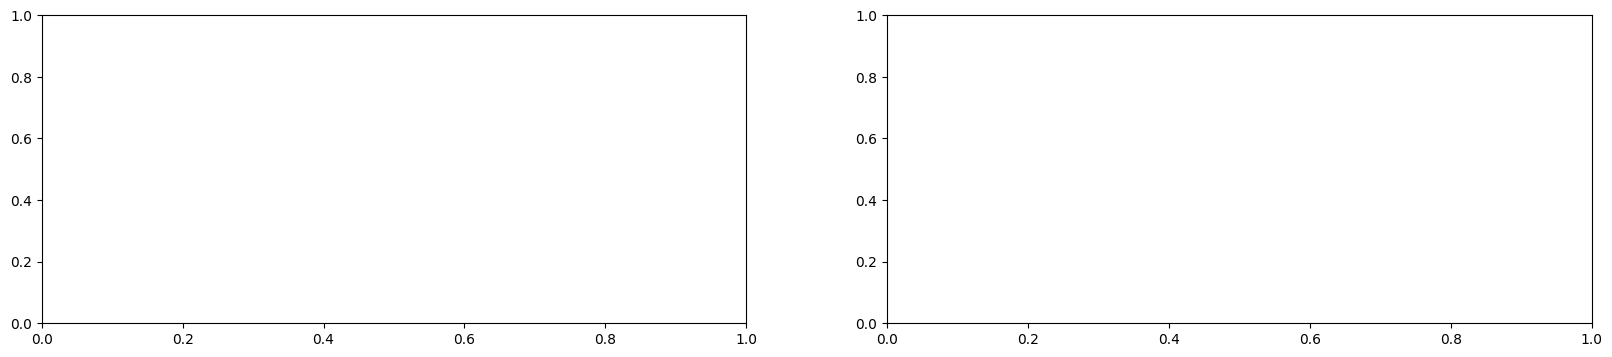

In [23]:
impath = "4/0.png"
my_gain = cv2.imread("data/train_bigger/" + impath, cv2.IMREAD_UNCHANGED)
their_gain = cv2.imread("data/with_gain/" + impath, cv2.IMREAD_UNCHANGED)
settings = pd.read_csv('data/params.csv')

acq_time = settings['ms'][3]
show_image_spectra(my_gain, image_gain=0, acq_time=acq_time)
show_image_spectra(their_gain, image_gain=0, acq_time=acq_time)

In [3]:
from src.utils import *

stitch_images("results/physinf_noclamp")

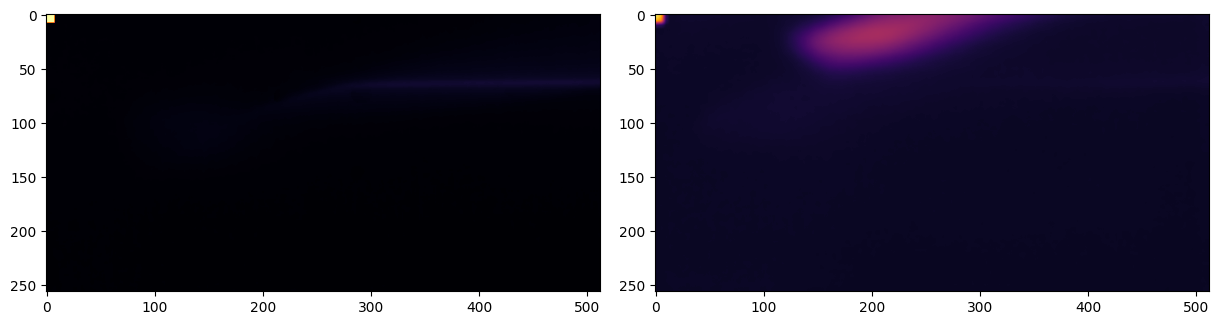

In [19]:
from metrics import *
import matplotlib.pyplot as plt

def compare_avg_plot(im1, im2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    axs[0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
    axs[1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
    plt.show()

def compare_avg_plots(real_root, sample_root)

im1, im2 = compare_avg("with_gain/17", "results/transfer_withgain_512_valid/no_17")
compare_avg_plot(im1, im2)


In [ ]:
def plot_average_pairs(real_root, sample_root):
    n = len(os.listdir(sample_root))
    fig, axs = plt.subplots(n, 2, figsize=(15, 4*n))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    for i in range(n):
        im1, im2 = compare_avg(os.path.join(real_root, n + 1), os.path.join(sample_root, "no_" + str(n + 1)))
        axs[i, 0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
        axs[i, 0].set_title(f'Experiment {i + 1}, real')
        axs[i, 1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
        axs[i, 1].set_title(f'Sampled')
    plt.show()

In [1]:
import scipy
mat = scipy.io.loadmat('Deflection_curve_Mixture_Feb28.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun  9 10:51:13 2022',
 '__version__': '1.0',
 '__globals__': [],
 'deflection_Mix': array([[122.382 ,   1.3238],
        [113.1797,   1.4117],
        [ 83.9496,   1.8423],
        [ 75.1443,   2.0471],
        [ 68.2294,   2.2489],
        [ 62.4582,   2.4547],
        [ 53.8108,   2.8523],
        [ 45.6837,   3.3718],
        [ 39.7447,   3.8922],
        [ 35.822 ,   4.3338],
        [ 32.6297,   4.7734],
        [ 30.4251,   5.132 ],
        [ 28.6947,   5.4527],
        [ 26.972 ,   5.8133],
        [ 26.4405,   5.9342],
        [ 24.371 ,   6.4557],
        [ 22.2446,   7.0931],
        [ 20.5504,   7.6955],
        [ 18.9303,   8.3728],
        [ 17.9293,   8.8523],
        [ 16.5427,   9.6126],
        [ 15.651 ,  10.172 ],
        [ 14.8498,  10.7325],
        [ 14.3008,  11.152 ],
        [ 13.6285,  11.7115],
        [ 13.0165,  12.2709],
        [ 12.3803,  12.9103],
        [ 11.944 ,  13.3878],
   

In [1]:
from src.dataset import read_img
import cv2

img = read_img("data/test/8_11.tiff")
img = img / 16 / 4095
cv2.imwrite("original.png", img*255)

True

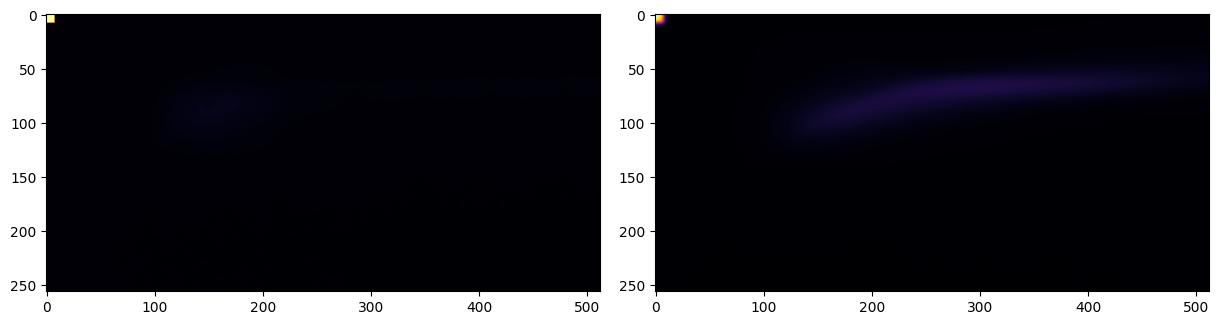

{'mse': tensor(787.7405), 'mse_norm': tensor(0.0002), 'dtw_dist': 414.08149948777964, 'ssim': tensor(0.8735, dtype=torch.float64)}


In [13]:
from metrics import *
import matplotlib.pyplot as plt
from src.utils import deflection_calc

def compare_avg_plot(im1, im2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    axs[0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
    axs[1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
    plt.show()

def plot_spectra(sp1, sp2, el_pointing_pixel=62):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    deflection_MeV = deflection_calc(1, len(sp1), el_pointing_pixel).flatten()
    ax1.plot(deflection_MeV, sp1)  # plot without fit
    ax1.set_title('Reconstructed Spectrum1')
    ax1.set_ylabel('Spectral Intensity (pA/MeV)')
    ax1.set_xlabel('Energy (MeV)')
    ax1.set_xlim([2, 20])
    ax2.plot(deflection_MeV, sp2)  # plot without fit
    ax2.set_title('Reconstructed Spectrum2')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)')
    ax2.set_xlabel('Energy (MeV)')
    ax2.set_xlim([2, 20])
    plt.show()

dirnum = 11

dir1 = 'data/with_gain/' + str(dirnum)
dir2 = 'results/valid_nophys_1000ns_sec25_cfg3/' + str(dirnum)

res, spectra = compare_spectra(dir1, dir2, dirnum)
img1, img2 = compare_avg(dir1, dir2)
compare_avg_plot(img1, img2)
print(res)
# plot_spectra(sp1, sp2)

In [1]:
from src.dataset import *

set_gain_all(Path("data/with_gain"), Path("data/gain50"))

100%|██████████| 22/22 [00:02<00:00,  7.93it/s]


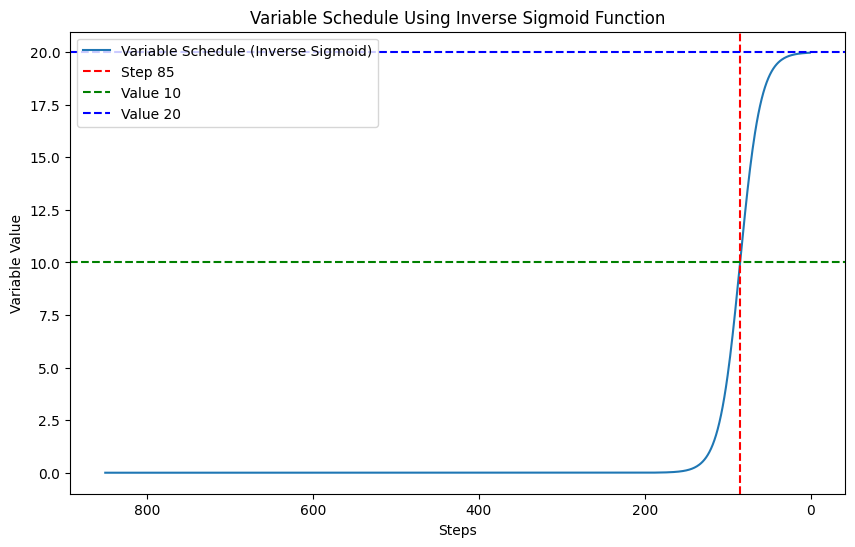

In [13]:
import numpy as np
import matplotlib.pyplot as plt
noise_steps = 850
# Define the step range
steps = np.arange(noise_steps, 0, -1)  # From 850 to 85

# Define sigmoid function parameters
x_0 = noise_steps/10  # Center point of the sigmoid, chosen to ensure the steep increase happens around step 85
k = 0.08  # Steepness of the curve


inverse_sigmoid_schedule = 20 - (20 / (1 + np.exp(-k * (steps - x_0))))

# Plotting the inverted sigmoid schedule
plt.figure(figsize=(10, 6))
plt.plot(steps, inverse_sigmoid_schedule, label='Variable Schedule (Inverse Sigmoid)')
plt.xlabel('Steps')
plt.ylabel('Variable Value')
plt.title('Variable Schedule Using Inverse Sigmoid Function')
plt.axvline(x=85, color='r', linestyle='--', label='Step 85')
plt.axhline(y=10, color='g', linestyle='--', label='Value 10')
plt.axhline(y=20, color='b', linestyle='--', label='Value 20')
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to show the decreasing steps correctly
plt.show()

Ratio: tensor([nan])
Ratio: tensor([nan])
Ratio: tensor([nan])
Ratio: tensor([nan])
Ratio: tensor([nan])
Ratio: tensor([nan])
Ratio: tensor([nan])
Ratio: tensor([nan])
Ratio: tensor([-0.3442])
Ratio: tensor([7.0764])
Ratio: tensor([7.0768])
Ratio: tensor([7.0773])
Ratio: tensor([7.0778])
Ratio: tensor([7.0783])
Ratio: tensor([7.0789])
Ratio: tensor([7.0795])
Ratio: tensor([7.0801])
Ratio: tensor([7.0807])
Ratio: tensor([7.0814])
Ratio: tensor([7.0821])
Ratio: tensor([7.0829])
Ratio: tensor([7.0837])
Ratio: tensor([7.0845])
Ratio: tensor([7.0854])
Ratio: tensor([7.0863])
Ratio: tensor([7.0873])
Ratio: tensor([7.0883])
Ratio: tensor([7.0894])
Ratio: tensor([7.0905])
Ratio: tensor([7.0916])
Ratio: tensor([7.0929])
Ratio: tensor([7.0941])
Ratio: tensor([7.0955])
Ratio: tensor([7.0969])
Ratio: tensor([7.0983])
Ratio: tensor([7.0998])
Ratio: tensor([7.1014])
Ratio: tensor([7.1030])
Ratio: tensor([7.1048])
Ratio: tensor([7.1065])
Ratio: tensor([7.1084])
Ratio: tensor([7.1102])
Ratio: tensor([

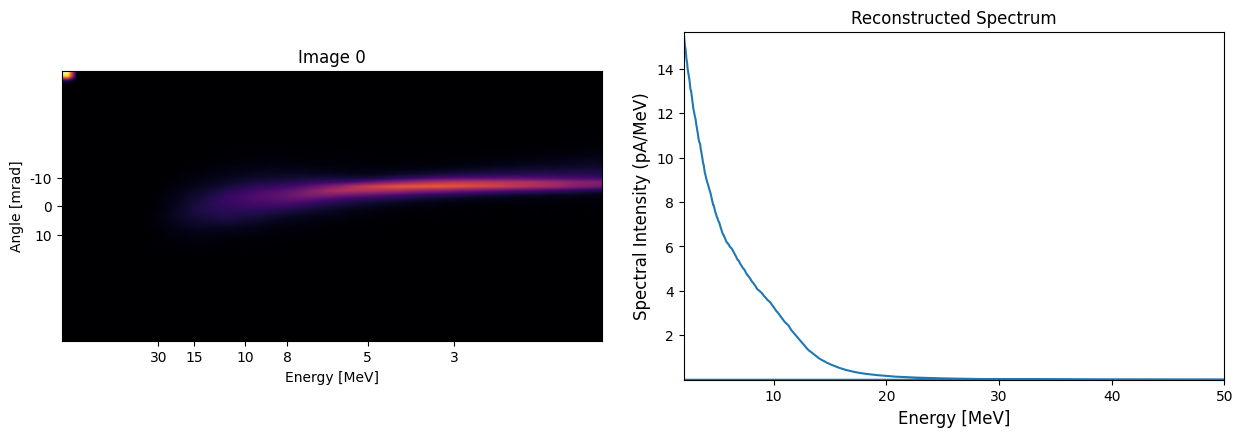

In [1]:
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib as mpl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import cv2
import glob
import src.dataset as dataset
import scipy
import torchvision.transforms.functional as f
from src.utils import load_images_from_dir, find_ticks


def bi_exponential_deflection(x, a1=77.855568601465, b1=0.466485822903793, a2=19.911755340829, b2=0.043573073167125255):
    return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)

def bi_exponential_deflection_dx(x, a1=-36.318518986697, b1=0.466485822903793, a2=-0.86761637235184, b2=0.043573073167125255):
    return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)


def deflection_biexp_calc(batch_size, hor_image_size, electron_pointing_pixel, pixel_in_mm=0.137):
    linear_space = torch.arange(hor_image_size) * pixel_in_mm
    linear_space -= electron_pointing_pixel * pixel_in_mm
    deflection_mm = linear_space.clamp(min=0)
    deflection_mm = deflection_mm.repeat(batch_size, 1)
    mask = deflection_mm > 1
    deflection_MeV = torch.zeros_like(deflection_mm)
    deflection_MeV_dx = torch.zeros_like(deflection_mm)
    deflection_MeV[mask] = bi_exponential_deflection(deflection_mm[mask]).to(torch.float32)
    deflection_MeV_dx[mask] = bi_exponential_deflection_dx(deflection_mm[mask]).to(torch.float32)
    return deflection_MeV, deflection_MeV_dx


def calc_spec(image, electron_pointing_pixel, deflection_MeV, acquisition_time_ms, image_gain=0, resize=None, noise=False, device='cpu', deflection_MeV_dx=None):
    if resize:
        image = f.resize(image, resize, antialias=True)
    image_gain /= 32 # correction for CCD settings
    if noise:
        noise = torch.median(torch.stack([image[:, :, int(image.shape[1]*0.9), int(image.shape[2]*0.05)],
                        image[:, :, int(image.shape[1]*0.9), int(image.shape[2]*0.9)],
                        image[:, :, int(image.shape[1]*0.1), int(image.shape[2]*0.9)]], dim=0), dim=(1, 2))
        noise = noise.unsqueeze(1).unsqueeze(2)
        image[image <= noise] = 0
    # acquisition_time_ms = 10
    hor_image_size = image.shape[-1]
    batch_size = image.shape[0]
    horizontal_profile = torch.sum(image, dim=(1, 2)).to(device)  # for plotting maybe dim=(1) works?
    spectrum_in_pixel = torch.zeros((batch_size, hor_image_size)).to(device)
    spectrum_in_MeV = torch.zeros((batch_size, hor_image_size)).to(device)
            
    for j in range(electron_pointing_pixel, hor_image_size):
        spectrum_in_pixel[:, j] = horizontal_profile[:,j]
        with torch.no_grad():
            derivative = deflection_MeV[:, j-1] - deflection_MeV[:, j] if deflection_MeV_dx is None else -deflection_MeV_dx[:, j] # 
            # print("Diff:", -deflection_MeV_dx[:, j] - deflection_MeV[:, j-1] + deflection_MeV[:, j])
            print("Ratio:", -deflection_MeV_dx[:, j] / (deflection_MeV[:, j-1] - deflection_MeV[:, j]))
            # print("Continuous:", -deflection_MeV_dx[:, j])
            # print(deflection_MeV[:, j-1] - deflection_MeV[:, j])
            # print(-deflection_MeV_dx[:, j])
            derivative = derivative.to(device)
            mask = derivative != 0
            spectrum_in_MeV[mask, j] = spectrum_in_pixel[mask, j] / derivative
            spectrum_in_MeV[~torch.isfinite(spectrum_in_MeV)] = 0

    acquisition_time_ms = acquisition_time_ms.reshape(batch_size, 1).repeat(1, hor_image_size).to(device)
    spectrum_calibrated = (spectrum_in_MeV * 3.706) / (acquisition_time_ms*image_gain) if image_gain else (spectrum_in_MeV * 3.706) / acquisition_time_ms
    return deflection_MeV, spectrum_calibrated


def plot_image_pairs(images, acquisition_time_ms, beam_point_x, beam_point_y, energy, pressure, xlim=[2, 20], model=1, gain=0, noise=False):
    def get_y_lims_within_xlim(x, y, xlim):
        """Find the min and max y-values within the specified x-limits using PyTorch."""
        within_xlim = (x >= xlim[0]) & (x <= xlim[1])
        y_within_xlim = y[within_xlim]
        return [torch.min(y_within_xlim), torch.max(y_within_xlim)] if y_within_xlim.numel() > 0 else [torch.min(y), torch.max(y)]

    n = len(images)
    pixel_in_mrad = 0.3653
    energy_levels = [100, 30, 15, 10, 8, 5, 3]  # Removed 40 and 20
    ranges = [(70, 101), (20, 31), (12, 15.5), (8, 10.5), (6, 8.2), (4.8, 5.2), (2.9, 3.2)]  # Adjusted ranges

    fig, axs = plt.subplots(n, 2, figsize=(15, 4*n))
    fig.subplots_adjust(hspace=0.35, wspace=0.15, top=0.98)
    if n == 1:
        axs = axs.reshape(1, -1)
    deflection_MeV, deflection_MeV_dx = deflection_biexp_calc(n, images.shape[-1], beam_point_x)
    deflection_MeV = deflection_MeV[0].unsqueeze(0) # make it batched but of batchsize 1
    deflection_MeV_dx = deflection_MeV_dx[0].unsqueeze(0) # make it batched but of batchsize 1
    for i in range(n):
        im = images[i].unsqueeze(0).unsqueeze(0)
        deflection_MeV, spectrum_calibrated = calc_spec(im/255, beam_point_x, deflection_MeV, torch.tensor(acquisition_time_ms), image_gain=gain, noise=noise, deflection_MeV_dx=deflection_MeV_dx)  # Using a local function
        ticks = find_ticks(deflection_MeV.squeeze().cpu(), beam_point_x, beam_point_y, pixel_in_mrad, energy_levels, ranges)
        # Plot the spectrum
        axs[i, 1].plot(deflection_MeV.squeeze().cpu(), spectrum_calibrated.squeeze().cpu())
        axs[i, 1].set_title('Reconstructed Spectrum', fontsize=12)
        axs[i, 1].set_ylabel('Spectral Intensity (pA/MeV)', fontsize=12)
        axs[i, 1].set_xlabel('Energy [MeV]', fontsize=12)
        axs[i, 1].set_xlim(xlim)
        y_lims = get_y_lims_within_xlim(deflection_MeV, spectrum_calibrated, xlim)
        axs[i, 1].set_ylim(y_lims)

        # Plot the image
        axs[i, 0].imshow(im.squeeze().cpu(), vmin=0, vmax=255, cmap='inferno')
        axs[i, 0].set_title(f"Image {i}")

        # Set y-axis ticks for mrad values
        axs[i, 0].set_yticks([ticks['tick_10mrad_px'], ticks['tick0mrad_px'], ticks['tick10mrad_px']])
        axs[i, 0].set_yticklabels(['-10', '0', '10'])
        axs[i, 0].set_ylabel('Angle [mrad]')

        # Set x-axis ticks for MeV values
        mev_ticks = [tick for key, tick in ticks.items() if 'MeV' in key and tick is not None]
        axs[i, 0].set_xticks(mev_ticks)
        axs[i, 0].set_xticklabels([key.split('tick')[1].replace('MeV', '') for key in ticks if 'MeV' in key and ticks[key] is not None])
        axs[i, 0].set_xlabel('Energy [MeV]')
        # deflection_MeV = deflection_MeV.unsqueeze(0)
    plt.show()


E = 15
P = 15
ms = 20
x = f.pil_to_tensor(load_images_from_dir("results/1st_gain50_beamposnoweight", 4)[0])
plot_image_pairs(x, xlim=[2,50], acquisition_time_ms=ms, beam_point_y=128, beam_point_x=64, energy=E, pressure=P, model=1, noise=False)

In [1]:
def sigmoid_schedule(step, max_steps=850, k=0.08):
    x_0 = max_steps/10
    return 20 - (20 / (1 + torch.exp(-k * (step - x_0))))

In [4]:
import torch

sigmoid_schedule(torch.tensor(211))

tensor(0.0008)